# Simulating Rabi oscillations with noise and decoherence

In this tutorial we walk through an example of solving using `qiskit_dynamics` the time evolution of a qubit being driven close to resonance. The model that we solve consists of a single qubit perturbed by a sinusoidal drive. In addition, will consider energy relaxation and decoherence terms modeled by using a Lindblad master equation.

In the sections below we define a model, solve the dynamics and plot the qubit oscillations using the following steps:
1. Define all relevant parameters and setup a `Solver` instance with the Hamiltonian model of the system.
2. Define the initial state and simulation times, and evolve the system state.
3. Plot the qubit state as a function of time and discuss the results.
4. Solve again the the model with jump operators for the Lindblad dissipator, and plot the results.

In the first step below, we model the time evolution of a qubit's state taken as a two-level system, using the Schrödinger equation with a Hamiltonian containing a diagonal term of frequency $\nu_z$ and a transverse term of amplitude $\nu_x$ and harmonic driving frequency $\nu_d$,

$$H = \frac{1}{2} \times 2 \pi \nu_z {Z} + 2 \pi \nu_x \cos(2 \pi \nu_d t){X},$$

where $\{X,Y,Z\}$ are the Pauli matrices (also written as $\sigma^a$ with $a\in\{x,y,z\}$).

## 1. Setup the solver with the Hamiltonian model

In the following, we will set $\hbar=1$ and fix some arbitrary time units, with all frequency parameters scaled accordingly. Below, we first set a few values for these frequency parameters, and then setp the `Solver` class instance that stores and manipulates the model to be solved, using matrices and `Signal` instances. For the time-independent $z$ term we set the signal to a constant, while for the trasverse driving term  we setup a harmonic signal.

In [1]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit_dynamics.signals import Signal


nu_z = 10.
nu_x = 1.
nu_d = 9.98  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = X + 1j * Y

solver = Solver(hamiltonian_operators = [Z, X],
                hamiltonian_signals = [Signal(.5 * 2 * np.pi * nu_z),
                                       Signal(envelope = 2 * np.pi * nu_x, carrier_freq = nu_d)])

## 2. Solve the system

We now define the initial state for the simulation, the time span to simulate for, and the intermediate times for which the solution is requested, and solve the evolution.

In [2]:
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import DensityMatrix

t_final = .5 / nu_x
tau = .005

y0 = Statevector([1., 0.])

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval)

## 3. Plot the qubit state

Below we define a local function that calculates the qubit's Pauli expectation values as a function of time (which define also the Bloch vector),

$$\langle X(t)\rangle, \langle Y(t)\rangle, \langle Z(t)\rangle.$$

The same function plots both these three curves, and the Bloch vector at the final time, depicted in 3D on the Bloch sphere. We will reuse this function in the next section.

We see that for the parameters we have defined, the qubit has completed almost exactly a $\pi$-rotation of the qubit Bloch vector about the $x$ axis, from the ground to the excited state (with many intermediate rotations of its transverse component, whose amplitude increases and decreases). This mechanism of Rabi oscillations is the basis for the single-qubit gates used to manipulate quantum devices - in particular this is a realization of the $X$ gate.

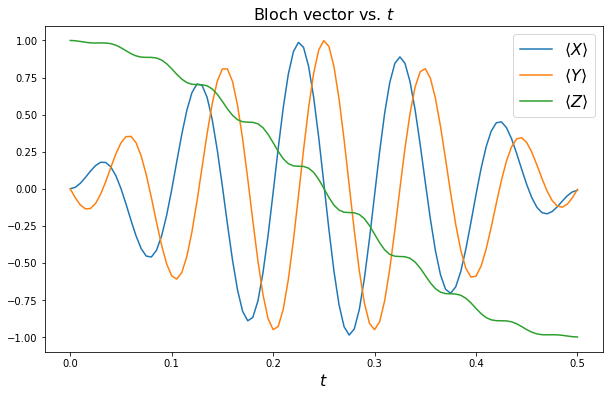

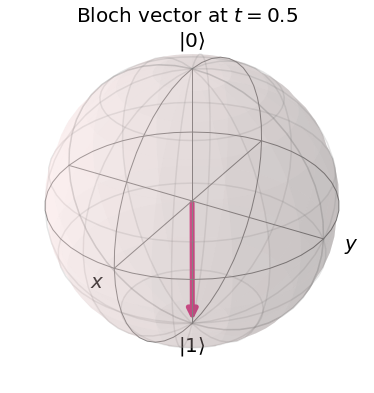

In [3]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real
    
    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                              f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)

## 4. Redefine the model with damping and decoherence.

Now we add to our simulation an environment modeled as a memory-less (Markovian) bath, solving the Lindblad master equation with the same Hamiltonian as before, but accounting also for energy relaxation and decoherence terms. We simulate the dynamics to times longer than the typical relaxation times $T_1=1/\Gamma_1$ and $T_{\phi}=1/\Gamma_2$. The qubit's state has to be described using a density matrix, now evolving according to the Lindblad master equation,

$$\partial_t\rho = -\frac{i}{\hbar} \left[H,\rho\right] + \mathcal{D}[\rho].$$

We take the Lindblad dissipator to consist of two terms,

$$\mathcal{D}[\rho] = \mathcal{D}_1[\rho] + \mathcal{D}_2[\rho].$$

The action of energy relaxation terms describing damping into the environment with rate $\Gamma_1$ are generated by

$$\mathcal{D}_1[\rho] = \Gamma_1\left(\sigma^+ \rho\sigma^- - \frac{1}{2} \{\sigma^- \sigma^+,\rho\}\right),$$

with $\sigma^{\pm}= \frac{1}{2}\left(X\pm Y\right)$.

The second dissipator describes ("pure") dephasing with rate $\Gamma_2$, and reads

$$\mathcal{D}_2[\rho] = \Gamma_2\left(Z \rho Z - \rho\right).$$

We use the function defined above for calculating the Bloch vector components, which can be done since in `qiskit` and in `qiskit-dynamics` the syntax of many functions is identical for both state vectors and density matrices. The shrinking of the qubit's state within the Bloch sphere due to the incoherent evolution can be clearly seen in the plots below.

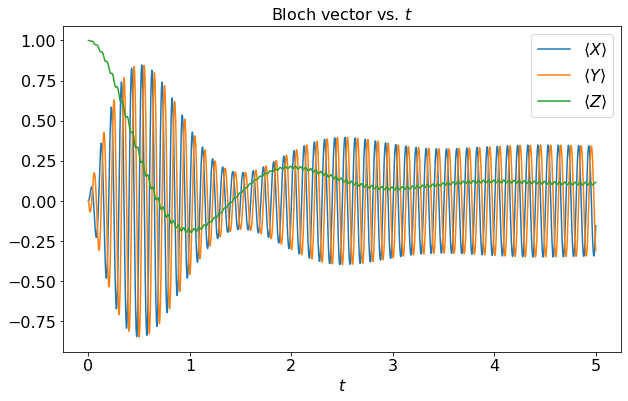

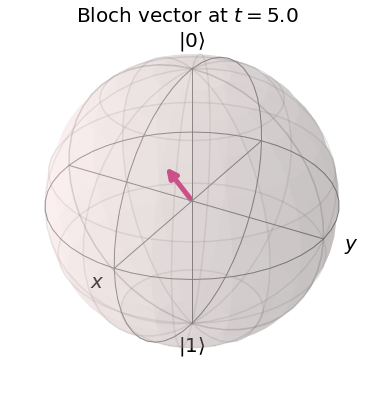

In [4]:
Gamma_1 = .3
Gamma_2 = .2

t_final = 1.5 / max(Gamma_1, Gamma_2)

y0 = DensityMatrix.from_label('0')
solver = Solver(hamiltonian_operators = [Z, X],
                hamiltonian_signals = [Signal(.5 * 2 * np.pi * nu_z),
                                       Signal(envelope = .5 * 2 * np.pi * nu_x, carrier_freq = nu_d)],
                dissipator_operators = [s_p, Z], dissipator_signals = [Gamma_1, Gamma_2])

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval)

plot_qubit_dynamics(sol, t_eval, X, Y, Z)